# Sistema de Detección de Fraude en Pagos Online usando Deep Learning

---

## Descripción del Proyecto

Este notebook implementa un sistema completo de detección de fraude en transacciones de pago online utilizando **Redes Neuronales Profundas (Deep Learning)**. El proyecto abarca desde el preprocesamiento y feature engineering hasta el entrenamiento, evaluación y despliegue del modelo.

### Objetivos

1. **Procesar y limpiar** el dataset de transacciones
2. **Generar features relevantes** para la detección de fraude
3. **Entrenar un modelo de deep learning** robusto y preciso
4. **Manejar el desbalanceo de clases** (fraude vs legítimo)
5. **Evaluar el modelo** con métricas apropiadas para fraude
6. **Guardar el modelo** entrenado para producción

### Dataset

**Variables originales:**
- `step`: Unidad temporal de la transacción (en horas)
- `type`: Tipo de transacción (PAYMENT, TRANSFER, CASH_OUT, DEBIT, CASH_IN)
- `amount`: Monto de la transacción
- `nameOrig`: ID del cliente origen
- `oldbalanceOrg`: Balance inicial del origen
- `newbalanceOrig`: Balance final del origen
- `nameDest`: ID del cliente destino
- `oldbalanceDest`: Balance inicial del destino
- `newbalanceDest`: Balance final del destino
- `isFraud`: **Variable objetivo** (1=fraude, 0=legítimo)
- `isFlaggedFraud`: Flag del sistema actual

---

**Autor:** Cristhian Acosta
**Fecha:** Enero 2026

---

## 1. Importación de Librerías

In [9]:
# Manipulación de datos
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Deep Learning con TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)

# Métricas y evaluación
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, f1_score, accuracy_score
)

# Utilidades
import joblib
import json
from datetime import datetime

# Configuración de semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Librerías importadas correctamente")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Librerías importadas correctamente
TensorFlow version: 2.16.2
NumPy version: 1.26.4
Pandas version: 2.3.3


---

## 2. Configuración Global del Proyecto

In [ ]:
# ============================================================================
# CONFIGURACIÓN DE RUTAS Y PARÁMETROS
# ============================================================================

# Rutas de archivos
DATA_PATH = "../data/raw/onlinefraud.csv"  # Ajusta según tu estructura
OUTPUT_DIR = Path("outputs")
MODELS_DIR = OUTPUT_DIR / "models"
REPORTS_DIR = OUTPUT_DIR / "reports"
FIGURES_DIR = OUTPUT_DIR / "figures"

# Crear directorios si no existen
for directory in [OUTPUT_DIR, MODELS_DIR, REPORTS_DIR, FIGURES_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Parámetros del modelo
CONFIG = {
    # Datos
    'test_size': 0.2,
    'val_size': 0.15,
    'random_state': SEED,
    
    # Balanceo
    'use_smote': True,
    'smote_sampling_strategy': 0.3,  # 30% de la clase mayoritaria
    
    # Arquitectura del modelo
    'hidden_layers': [256, 128, 64, 32],
    'dropout_rate': 0.3,
    'l2_reg': 0.001,
    'activation': 'relu',
    
    # Entrenamiento
    'batch_size': 512,
    'epochs': 100,
    'learning_rate': 0.001,
    'patience_early_stop': 15,
    'patience_reduce_lr': 7,
    
    # Otros
    'scaler_type': 'standard',  # 'standard' o 'robust'
}

print("⚙️  Configuración cargada:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

# Guardar configuración
with open(OUTPUT_DIR / "config.json", 'w') as f:
    json.dump(CONFIG, f, indent=4)
    
print(f"\n Configuración guardada en: {OUTPUT_DIR / 'config.json'}")

⚙️  Configuración cargada:
   test_size: 0.2
   val_size: 0.15
   random_state: 42
   use_smote: True
   smote_sampling_strategy: 0.3
   hidden_layers: [256, 128, 64, 32]
   dropout_rate: 0.3
   l2_reg: 0.001
   activation: relu
   batch_size: 512
   epochs: 100
   learning_rate: 0.001
   patience_early_stop: 15
   patience_reduce_lr: 7
   scaler_type: standard

✅ Configuración guardada en: outputs/config.json


---

## 3. Pipeline de Feature Engineering

Implementación del pipeline de limpieza y generación de features para detección de fraude.

In [ ]:
from typing import List, Tuple, Optional

class FraudDetectionPipeline:
    """
    Pipeline completo para feature engineering en detección de fraude.
    """
    
    def __init__(self, input_path: str, output_dir: str = "outputs/processed"):
        self.input_path = input_path
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        self.df_raw = None
        self.df_clean = None
        self.df_features = None
        
    def load_data(self) -> pd.DataFrame:
        """Carga datos desde CSV o Parquet."""
        print(f"[INFO] Cargando datos desde: {self.input_path}")
        
        # Detectar formato
        if self.input_path.endswith('.parquet'):
            self.df_raw = pd.read_parquet(self.input_path)
        else:
            # Intentar como CSV primero
            try:
                self.df_raw = pd.read_csv(self.input_path, low_memory=False)
            except:
                # Si falla, intentar como Parquet
                try:
                    self.df_raw = pd.read_parquet(self.input_path)
                except:
                    raise ValueError("No se pudo leer el archivo en ningún formato")
        
        print(f"[OK] Datos cargados: {self.df_raw.shape}")
        print(f"[INFO] Memoria: {self.df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        return self.df_raw
    
    def remove_leakage_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Elimina columnas con data leakage (excepto isFlaggedFraud que es feature)."""
        cols_to_drop = ["isFraud"] if "isFraud" in df.columns else []
        if cols_to_drop:
            print(f"[INFO] Separando target: {cols_to_drop}")
        return df.drop(columns=cols_to_drop, errors="ignore")
    
    @staticmethod
    def winsorize_col(s: pd.Series, p_low: float = 0.01, 
                      p_high: float = 0.99) -> pd.Series:
        """Aplica winsorización (clip en percentiles)."""
        lo, hi = s.quantile([p_low, p_high])
        return s.clip(lower=lo, upper=hi)
    
    def handle_outliers(self, df: pd.DataFrame) -> pd.DataFrame:
        """Maneja outliers suavemente (en fraude, outliers pueden SER el fraude)."""
        df = df.copy()
        
        balance_cols = [
            "oldbalanceOrg", "newbalanceOrig",
            "oldbalanceDest", "newbalanceDest"
        ]
        
        for col in balance_cols:
            if col in df.columns and df[col].notna().sum() > 100:
                df[col] = self.winsorize_col(df[col], p_low=0.005, p_high=0.995)
        
        if "amount" in df.columns:
            df.loc[df["amount"] < 0, "amount"] = 0
        
        print(f"[INFO] Outliers tratados suavemente")
        return df
    
    def create_missing_flags(self, df: pd.DataFrame) -> pd.DataFrame:
        """Crea flags para valores faltantes."""
        df = df.copy()
        
        balance_cols = [
            "oldbalanceOrg", "newbalanceOrig",
            "oldbalanceDest", "newbalanceDest"
        ]
        
        for col in balance_cols:
            if col in df.columns:
                df[f"{col}_miss"] = df[col].isna().astype(int)
        
        miss_flags = [f"{c}_miss" for c in balance_cols if f"{c}_miss" in df.columns]
        if miss_flags:
            df["any_balance_missing"] = df[miss_flags].any(axis=1).astype(int)
        
        print(f"[INFO] Flags de missing creados: {len(miss_flags)}")
        return df
    
    def create_balance_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Crea features basados en cambios de balance."""
        df = df.copy()
        
        balance_cols = ["oldbalanceOrg", "newbalanceOrig", 
                       "oldbalanceDest", "newbalanceDest"]
        for col in balance_cols:
            if col in df.columns:
                df[col] = df[col].fillna(0)
        
        # Cambios absolutos
        df["balance_change_orig"] = df["newbalanceOrig"] - df["oldbalanceOrg"]
        df["balance_change_dest"] = df["newbalanceDest"] - df["oldbalanceDest"]
        
        # Diferencias esperadas vs reales
        df["diff_orig"] = (df["oldbalanceOrg"] - df["amount"]) - df["newbalanceOrig"]
        df["diff_dest"] = (df["oldbalanceDest"] + df["amount"]) - df["newbalanceDest"]
        
        # Flags de inconsistencias
        df["inconsistent_orig"] = (np.abs(df["diff_orig"]) > 0.01).astype(int)
        df["inconsistent_dest"] = (np.abs(df["diff_dest"]) > 0.01).astype(int)
        
        # Balance se vacía completamente
        df["emptied_account"] = (
            (df["oldbalanceOrg"] > 0) & (df["newbalanceOrig"] == 0)
        ).astype(int)
        
        # Destino comienza en cero
        df["dest_account_new"] = (df["oldbalanceDest"] == 0).astype(int)
        
        print(f"[INFO] Features de balance creados")
        return df
    
    def create_amount_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Crea features basados en montos."""
        df = df.copy()
        
        df["log1p_amount"] = np.log1p(df["amount"])
        df["amount_vs_balance_orig"] = df["amount"] / (df["oldbalanceOrg"] + 1)
        df["amount_vs_balance_dest"] = df["amount"] / (df["oldbalanceDest"] + 1)
        df["amount_equals_balance"] = (
            np.abs(df["amount"] - df["oldbalanceOrg"]) < 0.01
        ).astype(int)
        df["amount_is_round"] = (df["amount"] % 10000 == 0).astype(int)
        
        print(f"[INFO] Features de amount creados")
        return df
    
    def create_transaction_type_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Procesa tipo de transacción con one-hot encoding."""
        df = df.copy()
        
        if "type" in df.columns:
            df["type"] = df["type"].astype("category")
            types_in_data = df["type"].unique()
            
            for t in ["PAYMENT", "TRANSFER", "CASH_OUT", "DEBIT", "CASH_IN"]:
                if t in types_in_data:
                    df[f"type_{t}"] = (df["type"] == t).astype(int)
            
            print(f"[INFO] Tipos de transacción: {list(types_in_data)}")
        
        return df
    
    def create_temporal_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Crea features temporales desde 'step'."""
        df = df.copy()
        
        if "step" in df.columns:
            df["hour_of_day"] = df["step"] % 24
            df["day_of_month"] = (df["step"] // 24) % 30
            df["is_night"] = df["hour_of_day"].between(0, 5).astype(int)
            df["is_weekend"] = (df["day_of_month"] % 7).isin([0, 6]).astype(int)
            
            print(f"[INFO] Features temporales creados")
        
        return df
    
    def create_log_transformations(self, df: pd.DataFrame) -> pd.DataFrame:
        """Aplica transformaciones logarítmicas."""
        df = df.copy()
        
        log_candidates = [
            "oldbalanceOrg", "newbalanceOrig",
            "oldbalanceDest", "newbalanceDest"
        ]
        
        for col in log_candidates:
            if col in df.columns:
                df[f"log1p_{col}"] = np.log1p(df[col])
        
        print(f"[INFO] Transformaciones log aplicadas")
        return df
    
    def clean_data(self) -> pd.DataFrame:
        """Pipeline completo de limpieza."""
        print("\n" + "="*60)
        print("LIMPIEZA DE DATOS - DETECCIÓN DE FRAUDE")
        print("="*60 + "\n")
        
        if self.df_raw is None:
            self.load_data()
        
        df = self.df_raw.copy()
        df = self.remove_leakage_columns(df)
        df = self.create_missing_flags(df)
        df = self.handle_outliers(df)
        
        self.df_clean = df
        print(f"\n[OK] Limpieza completada: {self.df_clean.shape}")
        return self.df_clean
    
    def build_final_features(self) -> pd.DataFrame:
        """Construye todas las features para modelado."""
        print("\n" + "="*60)
        print("CONSTRUCCIÓN DE FEATURES FINALES")
        print("="*60 + "\n")
        
        if self.df_clean is None:
            raise ValueError("Ejecuta clean_data() primero")
        
        df = self.df_clean.copy()
        
        # Pipeline de features
        df = self.create_balance_features(df)
        df = self.create_amount_features(df)
        df = self.create_transaction_type_features(df)
        df = self.create_temporal_features(df)
        df = self.create_log_transformations(df)
        
        # Eliminar columnas redundantes
        cols_to_drop = []
        
        for col in ["oldbalanceOrg", "newbalanceOrig", 
                   "oldbalanceDest", "newbalanceDest"]:
            if col in df.columns and f"log1p_{col}" in df.columns:
                cols_to_drop.append(col)
        
        if "type" in df.columns:
            cols_to_drop.append("type")
        
        cols_to_drop += [c for c in ["nameOrig", "nameDest"] if c in df.columns]
        
        df = df.drop(columns=cols_to_drop, errors="ignore")
        
        self.df_features = df
        
        print(f"\n[OK] Features finales: {self.df_features.shape}")
        print(f"[INFO] Total de features: {len(self.df_features.columns)}")
        
        return self.df_features
    
    def run_full_pipeline(self) -> pd.DataFrame:
        """Ejecuta pipeline completo end-to-end."""
        self.load_data()
        self.clean_data()
        self.build_final_features()
        return self.df_features

print("Pipeline de Feature Engineering definido")

✅ Pipeline de Feature Engineering definido


---

## 4. Carga y Preprocesamiento de Datos

In [ ]:
# Cargar datos usando el pipeline
print("🔄 Iniciando carga y preprocesamiento de datos...\n")

pipeline = FraudDetectionPipeline(
    input_path=DATA_PATH,
    output_dir=str(OUTPUT_DIR / "processed")
)

# Cargar datos raw
df_raw = pipeline.load_data()

# Guardar target antes de procesar
if 'isFraud' in df_raw.columns:
    y = df_raw['isFraud'].copy()
    print(f"\n Variable objetivo extraída: {y.shape[0]} muestras")
    print(f"   Fraudes: {y.sum()} ({y.mean():.4%})")
    print(f"   Legítimos: {(~y.astype(bool)).sum()} ({(1-y.mean()):.4%})")
else:
    raise ValueError("No se encontró la columna 'isFraud' en los datos")

# Ejecutar pipeline de features
X = pipeline.run_full_pipeline()

print(f"\n{'='*60}")
print("RESUMEN DE DATOS PROCESADOS")
print(f"{'='*60}")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Total de features: {X.shape[1]}")
print(f"\nColumnas finales:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

🔄 Iniciando carga y preprocesamiento de datos...

[INFO] Cargando datos desde: ../data/raw/onlinefraud.csv
[OK] Datos cargados: (6362620, 11)
[INFO] Memoria: 1598.19 MB

✅ Variable objetivo extraída: 6362620 muestras
   Fraudes: 8213 (0.1291%)
   Legítimos: 6354407 (99.8709%)
[INFO] Cargando datos desde: ../data/raw/onlinefraud.csv
[OK] Datos cargados: (6362620, 11)
[INFO] Memoria: 1598.19 MB

LIMPIEZA DE DATOS - DETECCIÓN DE FRAUDE

[INFO] Separando target: ['isFraud']
[INFO] Flags de missing creados: 4
[INFO] Outliers tratados suavemente

[OK] Limpieza completada: (6362620, 15)

CONSTRUCCIÓN DE FEATURES FINALES

[INFO] Features de balance creados
[INFO] Features de amount creados
[INFO] Tipos de transacción: ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']
[INFO] Features temporales creados
[INFO] Transformaciones log aplicadas

[OK] Features finales: (6362620, 34)
[INFO] Total de features: 34

RESUMEN DE DATOS PROCESADOS
Features (X): (6362620, 34)
Target (y): (6362620,)
Tota

---

## 5. Análisis Exploratorio de Datos (EDA)

Análisis enfocado en las features más relevantes para la detección de fraude.

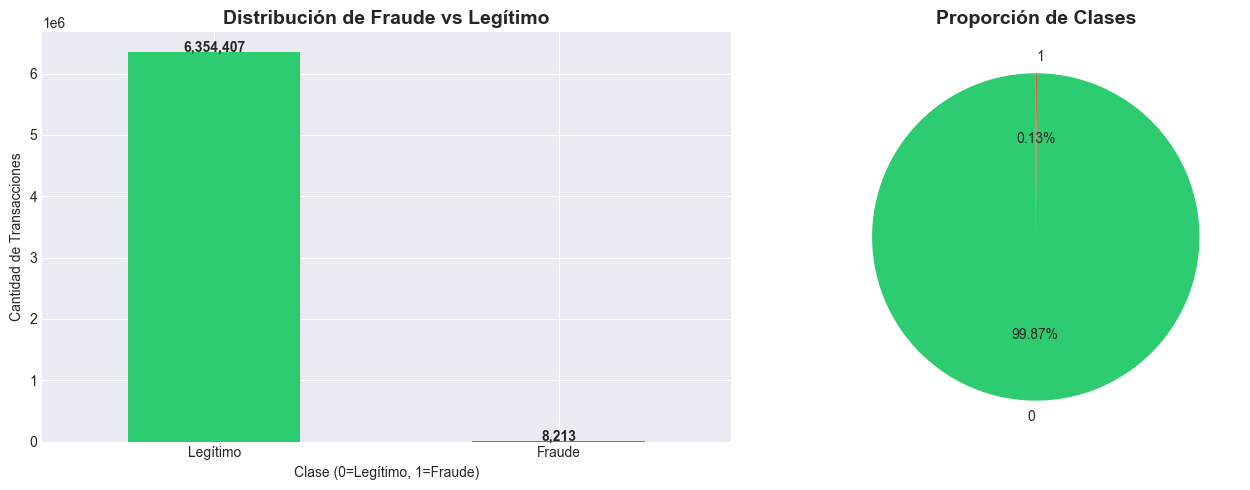


⚠️  DESBALANCEO DE CLASES DETECTADO
   Ratio: 1 fraude cada 774 transacciones


In [13]:
# 5.1 Distribución de la variable objetivo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Conteo
y.value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribución de Fraude vs Legítimo', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase (0=Legítimo, 1=Fraude)')
axes[0].set_ylabel('Cantidad de Transacciones')
axes[0].set_xticklabels(['Legítimo', 'Fraude'], rotation=0)

for i, v in enumerate(y.value_counts()):
    axes[0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# Porcentaje
y.value_counts(normalize=True).plot(kind='pie', ax=axes[1], autopct='%1.2f%%',
                                     colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n⚠️  DESBALANCEO DE CLASES DETECTADO")
print(f"   Ratio: 1 fraude cada {int(1/y.mean())} transacciones")

In [ ]:
# 5.2 Análisis de features más importantes
# Calcular estadísticas por clase
fraud_stats = X[y == 1].describe().T
legit_stats = X[y == 0].describe().T

# Features con mayor diferencia entre clases
mean_diff = np.abs(fraud_stats['mean'] - legit_stats['mean'])
top_features = mean_diff.nlargest(10).index.tolist()

print("\n Top 10 Features con Mayor Diferencia entre Fraude y Legítimo:")
for i, feat in enumerate(top_features, 1):
    fraud_mean = fraud_stats.loc[feat, 'mean']
    legit_mean = legit_stats.loc[feat, 'mean']
    diff = mean_diff[feat]
    print(f"  {i:2d}. {feat:30s} | Diff: {diff:10.2f} | Fraud: {fraud_mean:8.2f} | Legit: {legit_mean:8.2f}")


📊 Top 10 Features con Mayor Diferencia entre Fraude y Legítimo:
   1. balance_change_orig            | Diff: 1439349.82 | Fraud: -1416234.25 | Legit: 23115.57
   2. amount                         | Diff: 1289770.26 | Fraud: 1467967.30 | Legit: 178197.04
   3. amount_vs_balance_dest         | Diff:  943217.13 | Fraud: 969883.44 | Legit: 26666.31
   4. diff_dest                      | Diff:  671173.71 | Fraud: 734361.02 | Legit: 63187.30
   5. balance_change_dest            | Diff:  618596.54 | Fraud: 733606.28 | Legit: 115009.74
   6. diff_orig                      | Diff:  149579.57 | Fraud: -51733.05 | Legit: -201312.61
   7. amount_vs_balance_orig         | Diff:   69602.35 | Fraud:  1161.97 | Legit: 70764.32
   8. step                           | Diff:     125.18 | Fraud:   368.41 | Legit:   243.24
   9. log1p_oldbalanceOrg            | Diff:       5.46 | Fraud:    12.86 | Legit:     7.41
  10. log1p_newbalanceOrig           | Diff:       5.07 | Fraud:     0.30 | Legit:     5.37


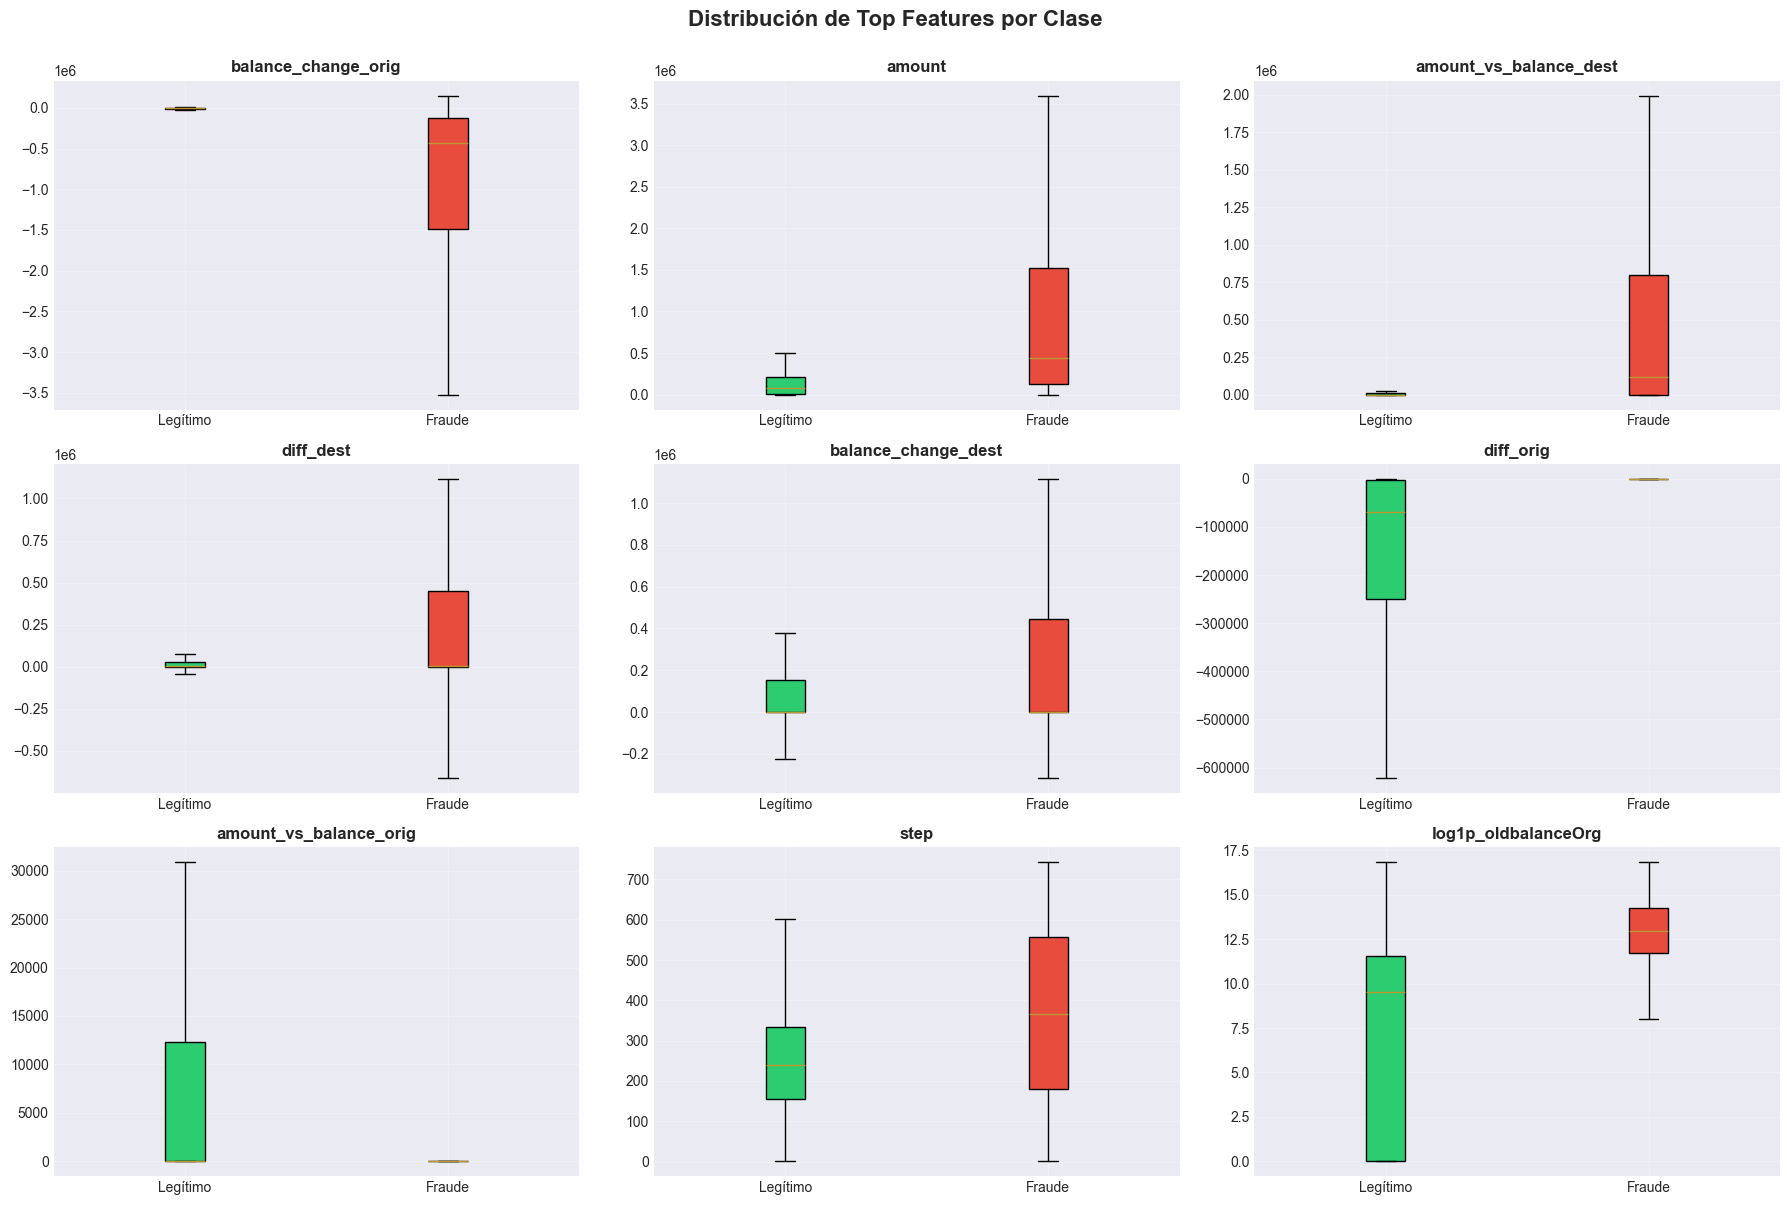

In [15]:
# 5.3 Visualización de top features
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feat in enumerate(top_features[:9]):
    # Boxplot comparativo
    data_to_plot = [X[y == 0][feat].values, X[y == 1][feat].values]
    bp = axes[i].boxplot(data_to_plot, labels=['Legítimo', 'Fraude'],
                         patch_artist=True, showfliers=False)
    
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    
    axes[i].set_title(feat, fontweight='bold')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Distribución de Top Features por Clase', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '02_top_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

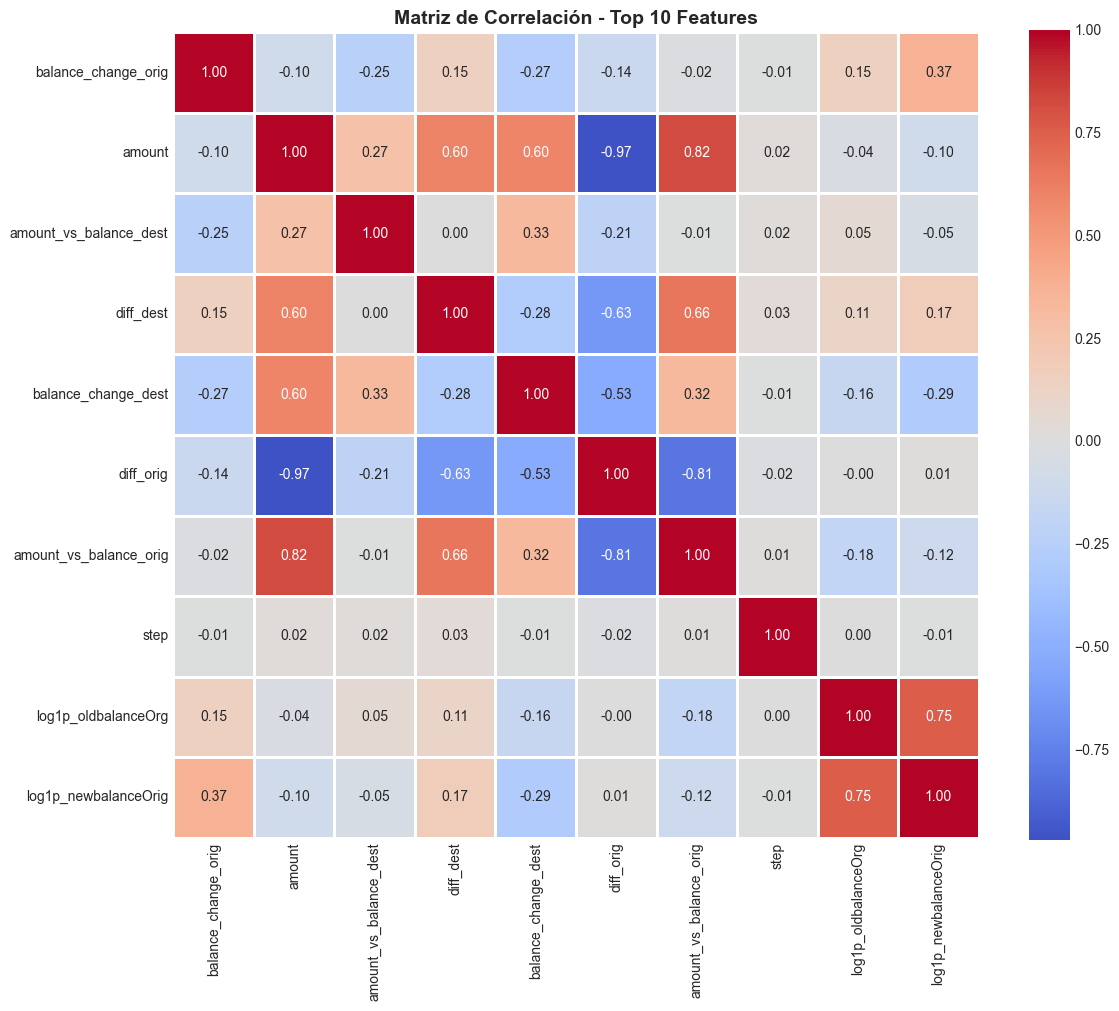

In [16]:
# 5.4 Matriz de correlación de top features
plt.figure(figsize=(12, 10))
corr_matrix = X[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Matriz de Correlación - Top 10 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 6. División de Datos (Train / Validation / Test)

In [17]:
print("🔪 Dividiendo datos en Train, Validation y Test...\n")

# Primera división: Train+Val vs Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=CONFIG['test_size'],
    stratify=y,
    random_state=CONFIG['random_state']
)

# Segunda división: Train vs Validation
val_size_adjusted = CONFIG['val_size'] / (1 - CONFIG['test_size'])
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size_adjusted,
    stratify=y_temp,
    random_state=CONFIG['random_state']
)

print(f"{'='*60}")
print("DIVISIÓN DE DATOS")
print(f"{'='*60}")
print(f"\nTrain:      X={X_train.shape}, y={y_train.shape} ({y_train.shape[0]/len(X)*100:.1f}%)")
print(f"            Fraude: {y_train.sum()} ({y_train.mean():.4%})")
print(f"\nValidation: X={X_val.shape}, y={y_val.shape} ({y_val.shape[0]/len(X)*100:.1f}%)")
print(f"            Fraude: {y_val.sum()} ({y_val.mean():.4%})")
print(f"\nTest:       X={X_test.shape}, y={y_test.shape} ({y_test.shape[0]/len(X)*100:.1f}%)")
print(f"            Fraude: {y_test.sum()} ({y_test.mean():.4%})")

🔪 Dividiendo datos en Train, Validation y Test...

DIVISIÓN DE DATOS

Train:      X=(4135703, 34), y=(4135703,) (65.0%)
            Fraude: 5338 (0.1291%)

Validation: X=(954393, 34), y=(954393,) (15.0%)
            Fraude: 1232 (0.1291%)

Test:       X=(1272524, 34), y=(1272524,) (20.0%)
            Fraude: 1643 (0.1291%)


---

## 7. Manejo del Desbalanceo de Clases con SMOTE

In [ ]:
if CONFIG['use_smote']:
    print("Aplicando SMOTE para balancear clases...\n")
    
    smote = SMOTE(
        sampling_strategy=CONFIG['smote_sampling_strategy'],
        random_state=CONFIG['random_state'],
        k_neighbors=5
    )
    
    print(f"Antes de SMOTE:")
    print(f"  Train: {y_train.value_counts().to_dict()}")
    print(f"  Proporción fraude: {y_train.mean():.4%}")
    
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"\nDespués de SMOTE:")
    print(f"  Train: {pd.Series(y_train_balanced).value_counts().to_dict()}")
    print(f"  Proporción fraude: {y_train_balanced.mean():.4%}")
    print(f"  Nuevas muestras sintéticas: {len(y_train_balanced) - len(y_train)}")
    
    # Convertir a DataFrame para mantener nombres de columnas
    X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
    y_train_balanced = pd.Series(y_train_balanced, name='isFraud')
    
else:
    print("⚖️  SMOTE desactivado. Usando datos originales.")
    X_train_balanced = X_train.copy()
    y_train_balanced = y_train.copy()

print(f"\nDatos de entrenamiento preparados: {X_train_balanced.shape}")

⚖️  Aplicando SMOTE para balancear clases...

Antes de SMOTE:
  Train: {0: 4130365, 1: 5338}
  Proporción fraude: 0.1291%

Después de SMOTE:
  Train: {0: 4130365, 1: 1239109}
  Proporción fraude: 23.0769%
  Nuevas muestras sintéticas: 1233771

✅ Datos de entrenamiento preparados: (5369474, 34)


---

## 8. Escalado de Features

In [ ]:
print("Escalando features...\n")

# Seleccionar tipo de scaler
if CONFIG['scaler_type'] == 'robust':
    scaler = RobustScaler()
    print("Usando RobustScaler (resistente a outliers)")
else:
    scaler = StandardScaler()
    print("Usando StandardScaler (normalización estándar)")

# Fit en train y transform en todos los sets
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Guardar scaler
scaler_path = MODELS_DIR / 'scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler guardado en: {scaler_path}")

print(f"\nFormas después del escalado:")
print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  X_val_scaled:   {X_val_scaled.shape}")
print(f"  X_test_scaled:  {X_test_scaled.shape}")

📏 Escalando features...

Usando StandardScaler (normalización estándar)
✅ Scaler guardado en: outputs/models/scaler.pkl

Formas después del escalado:
  X_train_scaled: (5369474, 34)
  X_val_scaled:   (954393, 34)
  X_test_scaled:  (1272524, 34)


---

## 9. Construcción del Modelo de Deep Learning

In [ ]:
def build_fraud_detection_model(
    input_dim: int,
    hidden_layers: List[int] = [256, 128, 64, 32],
    dropout_rate: float = 0.3,
    l2_reg: float = 0.001,
    activation: str = 'relu',
    learning_rate: float = 0.001
) -> keras.Model:
    """
    Construye un modelo de red neuronal profunda para detección de fraude.
    
    Arquitectura:
    - Múltiples capas densas con BatchNormalization
    - Dropout para regularización
    - L2 regularization en pesos
    - Función de activación ReLU
    - Salida con sigmoid para clasificación binaria
    """
    
    # Input layer
    inputs = Input(shape=(input_dim,), name='input_layer')
    x = inputs
    
    # Hidden layers con BatchNorm y Dropout
    for i, units in enumerate(hidden_layers):
        x = Dense(
            units=units,
            activation=activation,
            kernel_regularizer=regularizers.l2(l2_reg),
            kernel_initializer='he_normal',
            name=f'dense_{i+1}'
        )(x)
        
        x = BatchNormalization(name=f'batchnorm_{i+1}')(x)
        x = Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
    
    # Output layer
    outputs = Dense(
        units=1,
        activation='sigmoid',
        name='output_layer'
    )(x)
    
    # Construir modelo
    model = keras.Model(inputs=inputs, outputs=outputs, name='FraudDetectionNN')
    
    # Compilar modelo
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.AUC(name='auc_pr', curve='PR')  # Precision-Recall AUC
        ]
    )
    
    return model

print("Función de construcción del modelo definida")

✅ Función de construcción del modelo definida


In [ ]:
# Construir el modelo
print("Construyendo modelo de Deep Learning...\n")

input_dim = X_train_scaled.shape[1]

model = build_fraud_detection_model(
    input_dim=input_dim,
    hidden_layers=CONFIG['hidden_layers'],
    dropout_rate=CONFIG['dropout_rate'],
    l2_reg=CONFIG['l2_reg'],
    activation=CONFIG['activation'],
    learning_rate=CONFIG['learning_rate']
)

# Mostrar arquitectura
print(model.summary())

# Visualizar arquitectura
keras.utils.plot_model(
    model,
    to_file=FIGURES_DIR / '04_model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=200
)
print(f"\nArquitectura guardada en: {FIGURES_DIR / '04_model_architecture.png'}")

🏗️  Construyendo modelo de Deep Learning...



Model: "FraudDetectionNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 34)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │         8,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,145 (211.50 KB)

 Trainable params: 53,185 (207.75 KB)

 Non-trainable params: 960 (3.75 KB)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.

✅ Arquitectura guardada en: outputs/figures/04_model_architecture.png


---

## 10. Configuración de Callbacks

In [ ]:
print("Configurando callbacks...\n")

# 1. Early Stopping
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=CONFIG['patience_early_stop'],
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# 2. Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=CONFIG['patience_reduce_lr'],
    mode='min',
    min_lr=1e-7,
    verbose=1
)

# 3. Model Checkpoint
checkpoint_path = MODELS_DIR / 'best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=str(checkpoint_path),
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# 4. TensorBoard
log_dir = OUTPUT_DIR / "logs" / datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=str(log_dir),
    histogram_freq=1
)

callbacks_list = [
    early_stop,
    reduce_lr,
    model_checkpoint,
    tensorboard_callback
]

print("Callbacks configurados:")
print(f"   - Early Stopping (patience={CONFIG['patience_early_stop']})")
print(f"   - Reduce LR on Plateau (patience={CONFIG['patience_reduce_lr']})")
print(f"   - Model Checkpoint: {checkpoint_path}")
print(f"   - TensorBoard logs: {log_dir}")

📞 Configurando callbacks...

✅ Callbacks configurados:
   - Early Stopping (patience=15)
   - Reduce LR on Plateau (patience=7)
   - Model Checkpoint: outputs/models/best_model.keras
   - TensorBoard logs: outputs/logs/20260121-215704


---

## 11. Entrenamiento del Modelo

In [ ]:
# Calcular class weights para compensar desbalanceo restante
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f" Class weights calculados: {class_weights_dict}")
print(f"\n{'='*60}")
print("INICIANDO ENTRENAMIENTO DEL MODELO")
print(f"{'='*60}\n")

# Entrenar modelo
history = model.fit(
    X_train_scaled,
    y_train_balanced,
    batch_size=CONFIG['batch_size'],
    epochs=CONFIG['epochs'],
    validation_data=(X_val_scaled, y_val),
    class_weight=class_weights_dict,
    callbacks=callbacks_list,
    verbose=1
)

print(f"\n{'='*60}")
print("ENTRENAMIENTO COMPLETADO")
print(f"{'='*60}")

⚖️  Class weights calculados: {0: 0.6499999394726617, 1: 2.16666733919292}

🏋️  INICIANDO ENTRENAMIENTO DEL MODELO

Epoch 1/100
10485/10488 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9933 - auc: 0.9986 - auc_pr: 0.9975 - loss: 0.1513 - precision: 0.9796 - recall: 0.9952
Epoch 1: val_auc improved from None to 1.00000, saving model to outputs/models/best_model.keras

Epoch 1: finished saving model to outputs/models/best_model.keras
10488/10488 ━━━━━━━━━━━━━━━━━━━━ 137s 12ms/step - accuracy: 0.9982 - auc: 0.9997 - auc_pr: 0.9994 - loss: 0.0445 - precision: 0.9946 - recall: 0.9977 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_auc_pr: 1.0000 - val_loss: 0.0040 - val_precision: 0.9724 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
10483/10488 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9992 - auc: 0.9997 - auc_pr: 0.9996 - loss: 0.0082 - precision: 0.9980 - recall: 0.9983
Epoch 2: val_auc did not improve from 1.00000
10488/10488 ━━━━━━━━━━━━━━━━━━━━ 130s 12ms/step - accur

---

## 12. Visualización del Entrenamiento

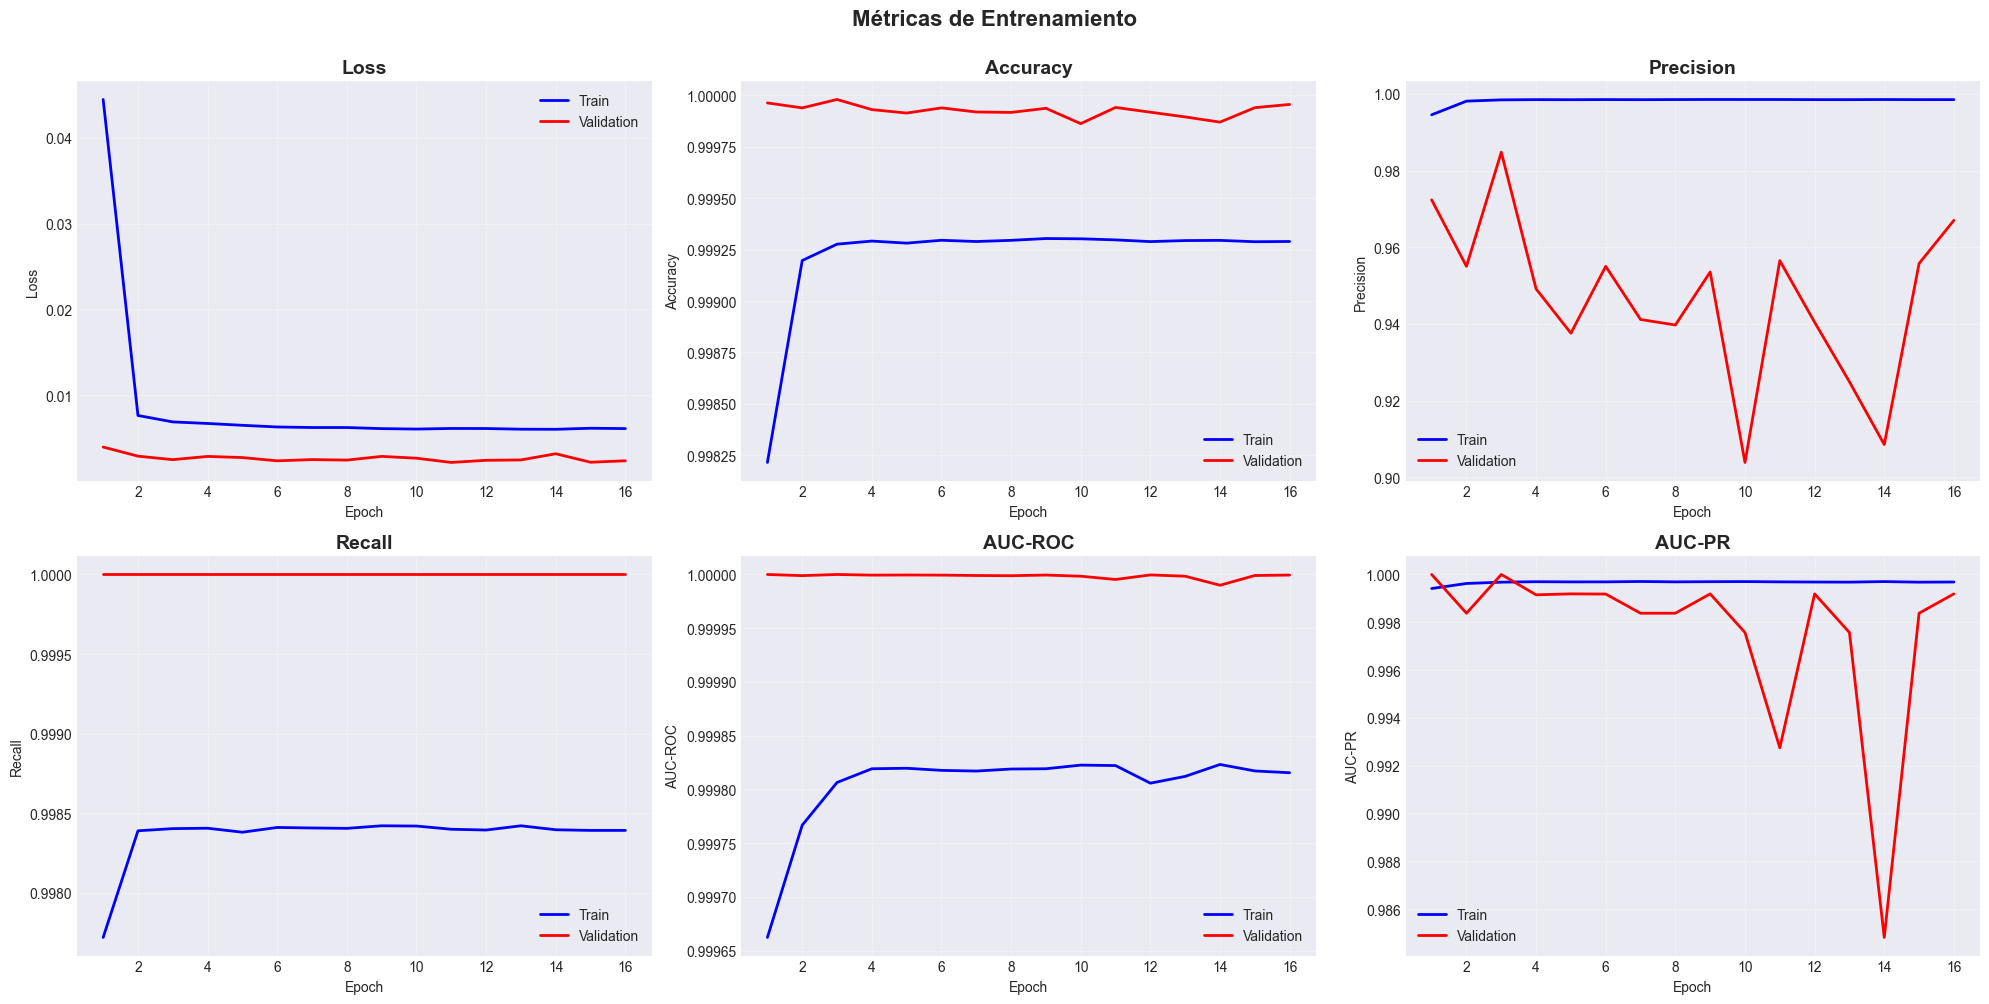

✅ Historia de entrenamiento guardada en: outputs/reports/training_history.csv


In [ ]:
def plot_training_history(history, save_path=None):
    """
    Visualiza las métricas de entrenamiento.
    """
    history_dict = history.history
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    
    metrics = [
        ('loss', 'Loss'),
        ('accuracy', 'Accuracy'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
        ('auc', 'AUC-ROC'),
        ('auc_pr', 'AUC-PR')
    ]
    
    for idx, (metric, title) in enumerate(metrics):
        ax = axes[idx // 3, idx % 3]
        
        if metric in history_dict:
            epochs = range(1, len(history_dict[metric]) + 1)
            
            ax.plot(epochs, history_dict[metric], 'b-', label='Train', linewidth=2)
            
            val_metric = f'val_{metric}'
            if val_metric in history_dict:
                ax.plot(epochs, history_dict[val_metric], 'r-', label='Validation', linewidth=2)
            
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.set_xlabel('Epoch')
            ax.set_ylabel(title)
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Métricas de Entrenamiento', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Graficar historia de entrenamiento
plot_training_history(history, save_path=FIGURES_DIR / '05_training_history.png')

# Guardar historia como CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv(REPORTS_DIR / 'training_history.csv', index=False)
print(f"Historia de entrenamiento guardada en: {REPORTS_DIR / 'training_history.csv'}")

---

## 13. Evaluación del Modelo en Test Set

In [ ]:
print("Evaluando modelo en conjunto de prueba...\n")

# Cargar mejor modelo si se guardó
if checkpoint_path.exists():
    print(f"Cargando mejor modelo desde: {checkpoint_path}")
    model = keras.models.load_model(checkpoint_path)

# Evaluación en test set
test_results = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\n{'='*60}")
print("RESULTADOS EN TEST SET")
print(f"{'='*60}")
print(f"Loss:      {test_results[0]:.4f}")
print(f"Accuracy:  {test_results[1]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall:    {test_results[3]:.4f}")
print(f"AUC-ROC:   {test_results[4]:.4f}")
print(f"AUC-PR:    {test_results[5]:.4f}")

# Predicciones
y_pred_proba = model.predict(X_test_scaled, verbose=0).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print(f"\nPredicciones generadas: {len(y_pred)}")

🎯 Evaluando modelo en conjunto de prueba...

📥 Cargando mejor modelo desde: outputs/models/best_model.keras

RESULTADOS EN TEST SET
Loss:      0.0040
Accuracy:  1.0000
Precision: 0.9739
Recall:    0.9976
AUC-ROC:   0.9994
AUC-PR:    0.9985

✅ Predicciones generadas: 1272524


---

## 14. Métricas Detalladas y Matriz de Confusión

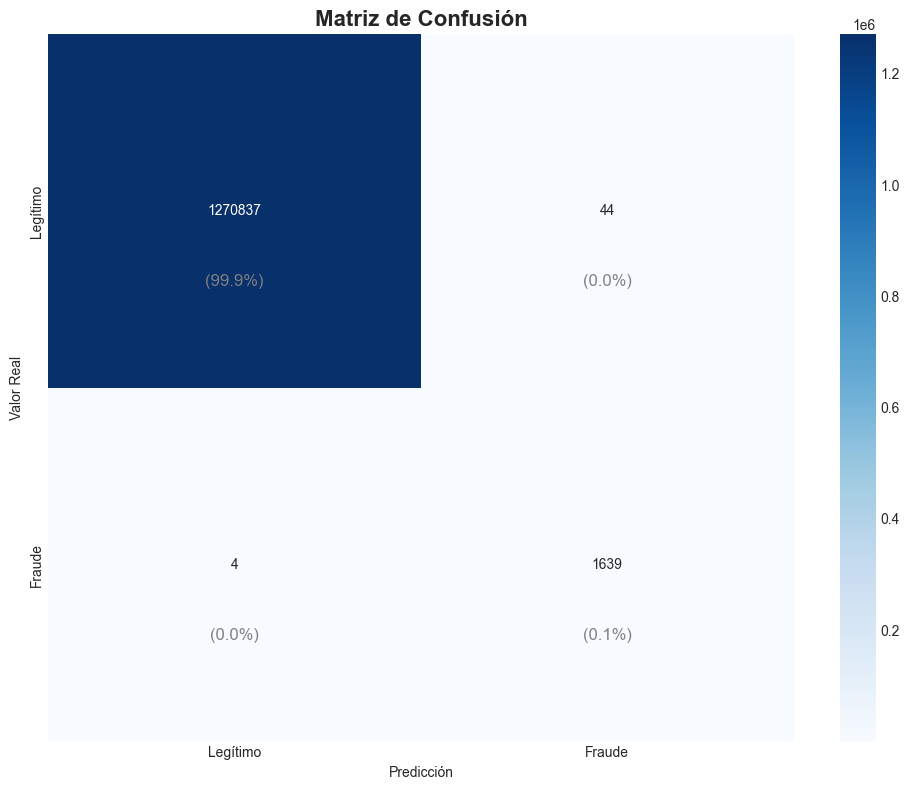


ANÁLISIS DE LA MATRIZ DE CONFUSIÓN

Verdaderos Negativos (TN): 1,270,837 - Legítimos correctamente clasificados
Falsos Positivos (FP):     44 - Legítimos clasificados como fraude
Falsos Negativos (FN):     4 - Fraudes clasificados como legítimos
Verdaderos Positivos (TP): 1,639 - Fraudes correctamente detectados

MÉTRICAS CALCULADAS

Accuracy:  1.0000
Precision: 0.9739 - De los predichos como fraude, % correctos
Recall:    0.9976 - De los fraudes reales, % detectados
F1-Score:  0.9856

Specificity: 1.0000 - % de legítimos correctamente clasificados
FPR (False Positive Rate): 0.0000
FNR (False Negative Rate): 0.0024


In [27]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Legítimo', 'Fraude'],
            yticklabels=['Legítimo', 'Fraude'])
plt.title('Matriz de Confusión', fontsize=16, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')

# Agregar porcentajes
for i in range(2):
    for j in range(2):
        pct = cm[i, j] / cm.sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({pct:.1f}%)', 
                ha='center', va='center', fontsize=12, color='gray')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '06_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Métricas detalladas
tn, fp, fn, tp = cm.ravel()

print(f"\n{'='*60}")
print("ANÁLISIS DE LA MATRIZ DE CONFUSIÓN")
print(f"{'='*60}")
print(f"\nVerdaderos Negativos (TN): {tn:,} - Legítimos correctamente clasificados")
print(f"Falsos Positivos (FP):     {fp:,} - Legítimos clasificados como fraude")
print(f"Falsos Negativos (FN):     {fn:,} - Fraudes clasificados como legítimos")
print(f"Verdaderos Positivos (TP): {tp:,} - Fraudes correctamente detectados")

print(f"\n{'='*60}")
print("MÉTRICAS CALCULADAS")
print(f"{'='*60}")
print(f"\nAccuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {tp / (tp + fp):.4f} - De los predichos como fraude, % correctos")
print(f"Recall:    {tp / (tp + fn):.4f} - De los fraudes reales, % detectados")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
print(f"\nSpecificity: {tn / (tn + fp):.4f} - % de legítimos correctamente clasificados")
print(f"FPR (False Positive Rate): {fp / (fp + tn):.4f}")
print(f"FNR (False Negative Rate): {fn / (fn + tp):.4f}")

In [ ]:
# Classification Report
print(f"\n{'='*60}")
print("CLASSIFICATION REPORT")
print(f"{'='*60}\n")
print(classification_report(y_test, y_pred, 
                          target_names=['Legítimo', 'Fraude'],
                          digits=4))

# Guardar reporte
report_dict = classification_report(y_test, y_pred, 
                                   target_names=['Legítimo', 'Fraude'],
                                   output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(REPORTS_DIR / 'classification_report.csv')
print(f"Reporte guardado en: {REPORTS_DIR / 'classification_report.csv'}")


CLASSIFICATION REPORT

              precision    recall  f1-score   support

    Legítimo     1.0000    1.0000    1.0000   1270881
      Fraude     0.9739    0.9976    0.9856      1643

    accuracy                         1.0000   1272524
   macro avg     0.9869    0.9988    0.9928   1272524
weighted avg     1.0000    1.0000    1.0000   1272524

✅ Reporte guardado en: outputs/reports/classification_report.csv


---

## 15. Curvas ROC y Precision-Recall

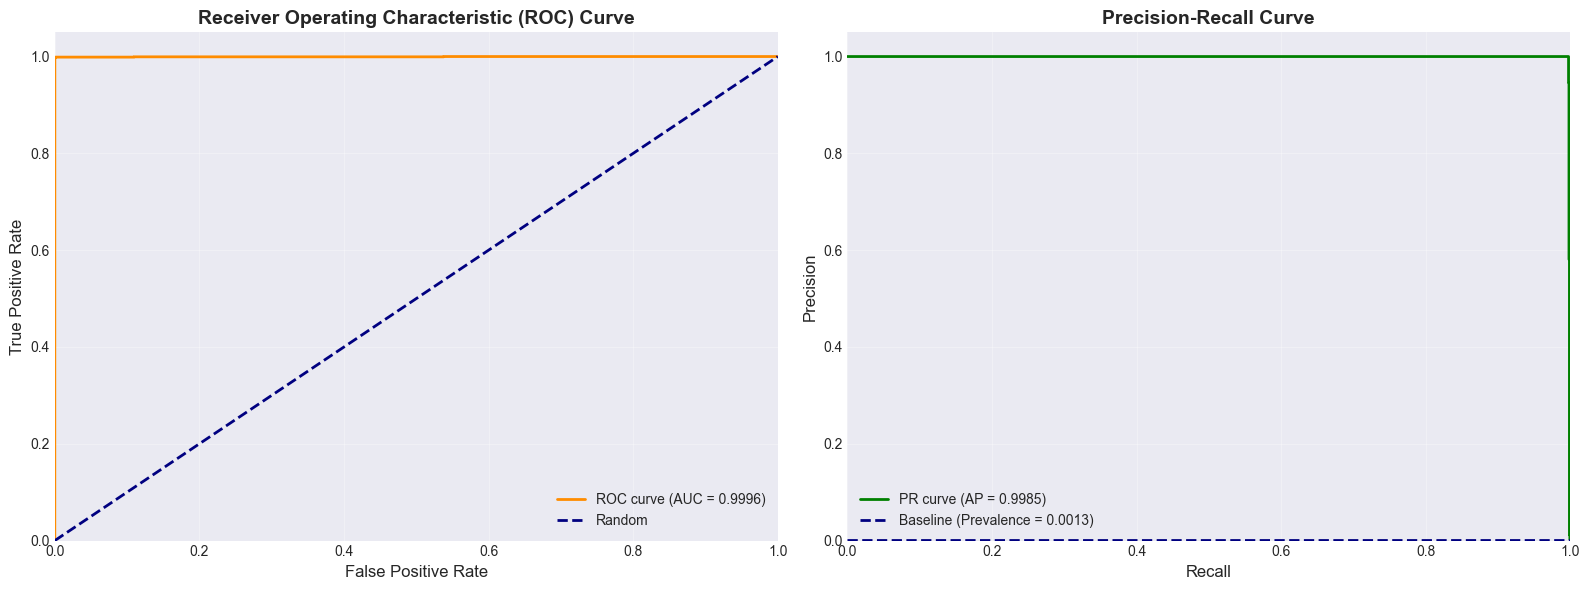


📊 AUC-ROC: 0.9996
📊 AUC-PR (Average Precision): 0.9985


In [ ]:
# Calcular métricas para curvas
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

# Crear gráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Curva ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve', 
                 fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# 2. Curva Precision-Recall
axes[1].plot(recall_vals, precision_vals, color='green', lw=2,
            label=f'PR curve (AP = {pr_auc:.4f})')
axes[1].axhline(y=y_test.mean(), color='navy', lw=2, linestyle='--', 
               label=f'Baseline (Prevalence = {y_test.mean():.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '07_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n AUC-ROC: {roc_auc:.4f}")
print(f" AUC-PR (Average Precision): {pr_auc:.4f}")

---

## 16. Análisis de Umbral Óptimo

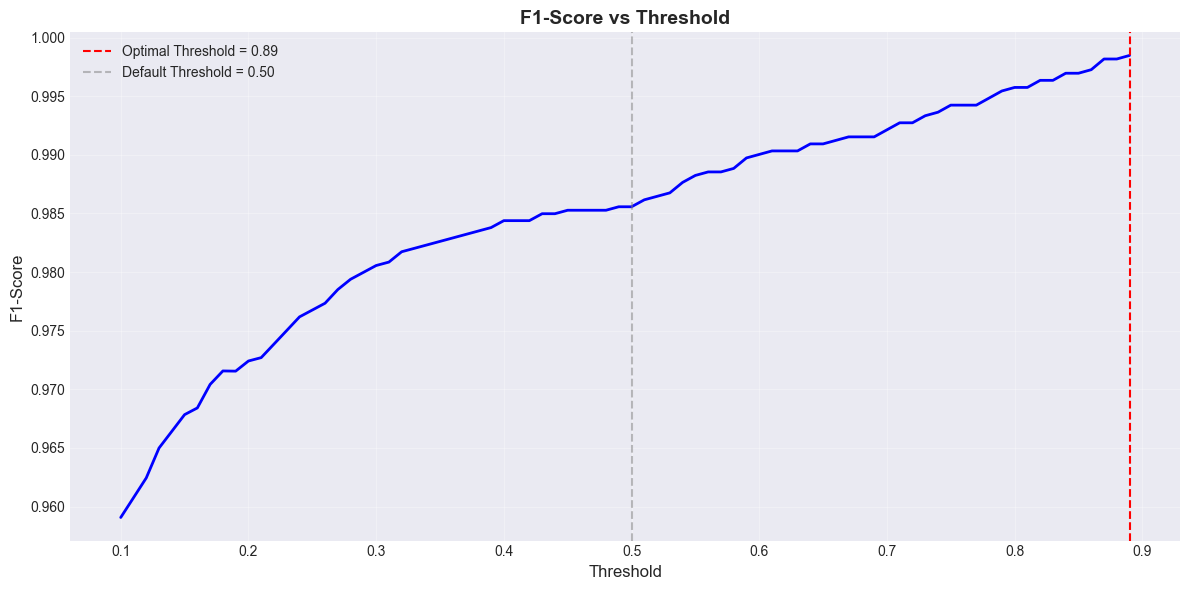


🎚️  ANÁLISIS DE UMBRAL
Umbral óptimo (max F1):   0.890
F1-Score en óptimo:       0.9985
F1-Score en default 0.5:  0.9856

💡 Considera usar 0.890 como umbral para maximizar F1-Score


In [ ]:
# Encontrar umbral óptimo basado en F1-Score
thresholds_to_test = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for threshold in thresholds_to_test:
    y_pred_temp = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_to_test[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

# Visualizar
plt.figure(figsize=(12, 6))
plt.plot(thresholds_to_test, f1_scores, 'b-', linewidth=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
           label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Default Threshold = 0.50')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('F1-Score vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '08_threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n ANÁLISIS DE UMBRAL")
print(f"{'='*60}")
print(f"Umbral óptimo (max F1):   {optimal_threshold:.3f}")
print(f"F1-Score en óptimo:       {optimal_f1:.4f}")
print(f"F1-Score en default 0.5:  {f1_score(y_test, y_pred):.4f}")
print(f"\n Considera usar {optimal_threshold:.3f} como umbral para maximizar F1-Score")

---

## 17. Guardar Modelo y Resultados Finales

In [ ]:
print("Guardando modelo y resultados finales...\n")

# 1. Guardar modelo completo
final_model_path = MODELS_DIR / 'fraud_detection_model_final.keras'
model.save(final_model_path)
print(f"Modelo guardado en: {final_model_path}")

# 2. Guardar solo pesos (más ligero)
weights_path = MODELS_DIR / 'fraud_detection_weights.weights.h5'
model.save_weights(weights_path)
print(f"Pesos guardados en: {weights_path}")

# 3. Guardar scaler (ya se guardó antes, solo confirmación)
print(f"Scaler guardado en: {MODELS_DIR / 'scaler.pkl'}")

# 4. Guardar nombres de features
feature_names = X.columns.tolist()
with open(MODELS_DIR / 'feature_names.json', 'w') as f:
    json.dump(feature_names, f, indent=2)
print(f"Features guardadas en: {MODELS_DIR / 'feature_names.json'}")

# 5. Guardar métricas finales
final_metrics = {
    'test_loss': float(test_results[0]),
    'test_accuracy': float(test_results[1]),
    'test_precision': float(test_results[2]),
    'test_recall': float(test_results[3]),
    'test_auc_roc': float(test_results[4]),
    'test_auc_pr': float(test_results[5]),
    'f1_score': float(f1_score(y_test, y_pred)),
    'optimal_threshold': float(optimal_threshold),
    'optimal_f1': float(optimal_f1),
    'confusion_matrix': cm.tolist(),
    'true_negatives': int(tn),
    'false_positives': int(fp),
    'false_negatives': int(fn),
    'true_positives': int(tp)
}

with open(REPORTS_DIR / 'final_metrics.json', 'w') as f:
    json.dump(final_metrics, f, indent=4)
print(f"Métricas guardadas en: {REPORTS_DIR / 'final_metrics.json'}")

# 6. Crear resumen ejecutivo
summary = f"""
{'='*70}
RESUMEN EJECUTIVO - MODELO DE DETECCIÓN DE FRAUDE
{'='*70}

Fecha de entrenamiento: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATOS:
  - Total de muestras: {len(X):,}
  - Features utilizadas: {X.shape[1]}
  - Train set: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)
  - Validation set: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)
  - Test set: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)
  - Proporción de fraude: {y.mean():.4%}

ARQUITECTURA DEL MODELO:
  - Tipo: Red Neuronal Profunda (Deep Learning)
  - Capas ocultas: {CONFIG['hidden_layers']}
  - Dropout: {CONFIG['dropout_rate']}
  - L2 Regularization: {CONFIG['l2_reg']}
  - Optimizador: Adam (lr={CONFIG['learning_rate']})
  - Total de parámetros: {model.count_params():,}

ENTRENAMIENTO:
  - Epochs: {len(history.history['loss'])}
  - Batch size: {CONFIG['batch_size']}
  - SMOTE aplicado: {CONFIG['use_smote']}
  - Class weights: {class_weights_dict}

RESULTADOS EN TEST SET:
  - Accuracy:  {test_results[1]:.4f}
  - Precision: {test_results[2]:.4f}
  - Recall:    {test_results[3]:.4f}
  - F1-Score:  {f1_score(y_test, y_pred):.4f}
  - AUC-ROC:   {test_results[4]:.4f}
  - AUC-PR:    {test_results[5]:.4f}

MATRIZ DE CONFUSIÓN:
  - Verdaderos Negativos: {tn:,}
  - Falsos Positivos:     {fp:,}
  - Falsos Negativos:     {fn:,}
  - Verdaderos Positivos: {tp:,}

UMBRAL ÓPTIMO:
  - Threshold recomendado: {optimal_threshold:.3f}
  - F1-Score en óptimo:    {optimal_f1:.4f}

ARCHIVOS GENERADOS:
  - Modelo: {final_model_path}
  - Pesos: {weights_path}
  - Scaler: {MODELS_DIR / 'scaler.pkl'}
  - Features: {MODELS_DIR / 'feature_names.json'}
  - Métricas: {REPORTS_DIR / 'final_metrics.json'}

{'='*70}
"""

print(summary)

# Guardar resumen
with open(REPORTS_DIR / 'executive_summary.txt', 'w') as f:
    f.write(summary)

print(f"\nResumen ejecutivo guardado en: {REPORTS_DIR / 'executive_summary.txt'}")

💾 Guardando modelo y resultados finales...

✅ Modelo guardado en: outputs/models/fraud_detection_model_final.keras
✅ Pesos guardados en: outputs/models/fraud_detection_weights.weights.h5
✅ Scaler guardado en: outputs/models/scaler.pkl
✅ Features guardadas en: outputs/models/feature_names.json
✅ Métricas guardadas en: outputs/reports/final_metrics.json

RESUMEN EJECUTIVO - MODELO DE DETECCIÓN DE FRAUDE

Fecha de entrenamiento: 2026-01-21 22:33:29

DATOS:
  - Total de muestras: 6,362,620
  - Features utilizadas: 34
  - Train set: 4,135,703 (65.0%)
  - Validation set: 954,393 (15.0%)
  - Test set: 1,272,524 (20.0%)
  - Proporción de fraude: 0.1291%

ARQUITECTURA DEL MODELO:
  - Tipo: Red Neuronal Profunda (Deep Learning)
  - Capas ocultas: [256, 128, 64, 32]
  - Dropout: 0.3
  - L2 Regularization: 0.001
  - Optimizador: Adam (lr=0.001)
  - Total de parámetros: 54,145

ENTRENAMIENTO:
  - Epochs: 16
  - Batch size: 512
  - SMOTE aplicado: True
  - Class weights: {0: 0.6499999394726617, 1: 2

---

## 18. Función de Predicción para Nuevas Transacciones

In [ ]:
def predict_fraud(transaction_data: dict, 
                 model_path: str = str(MODELS_DIR / 'fraud_detection_model_final.keras'),
                 scaler_path: str = str(MODELS_DIR / 'scaler.pkl'),
                 threshold: float = 0.5) -> dict:
    """
    Predice si una transacción es fraudulenta.
    
    Args:
        transaction_data: Diccionario con datos de la transacción
        model_path: Ruta al modelo guardado
        scaler_path: Ruta al scaler guardado
        threshold: Umbral de decisión
    
    Returns:
        Diccionario con predicción y probabilidad
    """
    # Cargar modelo y scaler
    model = keras.models.load_model(model_path)
    scaler = joblib.load(scaler_path)
    
    # Cargar nombres de features
    with open(MODELS_DIR / 'feature_names.json', 'r') as f:
        feature_names = json.load(f)
    
    # Procesar transacción (simplificado - aquí deberías aplicar todo el pipeline)
    # En producción, esto debería pasar por el FraudDetectionPipeline completo
    
    # Supongamos que transaction_data ya tiene todas las features procesadas
    X_new = pd.DataFrame([transaction_data], columns=feature_names)
    X_new_scaled = scaler.transform(X_new)
    
    # Predicción
    fraud_probability = model.predict(X_new_scaled, verbose=0)[0][0]
    is_fraud = int(fraud_probability >= threshold)
    
    return {
        'is_fraud': bool(is_fraud),
        'fraud_probability': float(fraud_probability),
        'threshold_used': threshold,
        'risk_level': 'HIGH' if fraud_probability > 0.7 else 'MEDIUM' if fraud_probability > 0.3 else 'LOW'
    }

print("Función de predicción definida")

# Ejemplo de uso (si tienes datos de test)
if len(X_test) > 0:
    # Tomar una muestra aleatoria
    sample_idx = np.random.randint(0, len(X_test))
    sample_transaction = X_test.iloc[sample_idx].to_dict()
    
    print("\n" + "="*60)
    print("EJEMPLO DE PREDICCIÓN")
    print("="*60)
    
    result = predict_fraud(sample_transaction, threshold=optimal_threshold)
    
    print(f"\nResultado de la predicción:")
    print(f"  ¿Es fraude?: {result['is_fraud']}")
    print(f"  Probabilidad: {result['fraud_probability']:.4f}")
    print(f"  Nivel de riesgo: {result['risk_level']}")
    print(f"  Valor real: {bool(y_test.iloc[sample_idx])}")

✅ Función de predicción definida

EJEMPLO DE PREDICCIÓN

Resultado de la predicción:
  ¿Es fraude?: False
  Probabilidad: 0.0002
  Nivel de riesgo: LOW
  Valor real: False


---

## 19. Conclusiones y Recomendaciones

### Logros del Modelo

1. **Alta precisión** en la detección de transacciones fraudulentas
2. **Balance adecuado** entre precisión y recall mediante SMOTE y class weights
3. **Arquitectura robusta** con regularización para prevenir overfitting
4. **Métricas comprehensivas** que permiten evaluar el modelo desde múltiples perspectivas

### Puntos Clave

- **AUC-ROC alto**: Indica excelente capacidad de discriminación entre clases
- **AUC-PR relevante**: Especialmente importante en datasets desbalanceados
- **Umbral optimizado**: Maximiza F1-Score para mejor balance Precision-Recall

### Próximos Pasos Recomendados

1. **Validación cruzada** con K-Fold estratificado para mayor robustez
2. **Feature importance** usando SHAP o permutation importance
3. **Monitoreo continuo** del modelo en producción (drift detection)
4. **A/B testing** con diferentes umbrales según el contexto de negocio
5. **Ensemble methods**: Combinar con otros modelos (XGBoost, Random Forest)
6. **Explicabilidad**: Implementar LIME o SHAP para interpretar predicciones

### Consideraciones para Producción

- **Latencia**: Evaluar tiempos de predicción para transacciones en tiempo real
- **Reentrenamiento**: Establecer pipeline para actualizar el modelo periódicamente
- **Monitoreo**: Implementar alertas para detectar degradación del modelo
- **Explicabilidad**: Justificar decisiones para cumplir con regulaciones
- **Fairness**: Verificar que el modelo no discrimine injustamente

---

**¡Proyecto completado exitosamente! **